# RNN with GRUs

Implemented as in *Shape and Time Distortion Loss for Training Deep Time Series Forecasting Models (2019)* https://arxiv.org/abs/1909.09020

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

import sys
sys.path.append('..')

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from metrics import calc_tdi_tdm, squared_error, absolute_error
from utilities import plot_forecasts, Evaluation
from datasets import Traffic, UCR18, split_dataset
from models.gru import EncoderRNN, DecoderRNN, GRUNet, train_model, get_forecasts

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# CONTROL PARAMS
TRAIN_MODEL = True

# Dataset: ECG5000

Training GRU model: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.44s/epoch, train_loss=0.0387]


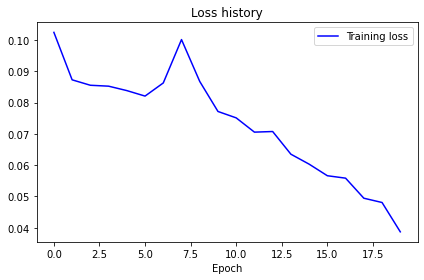

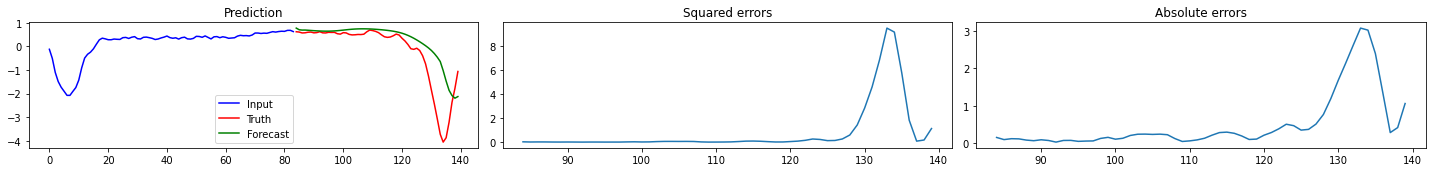

TDI: 0.20, TDM: 0.30 


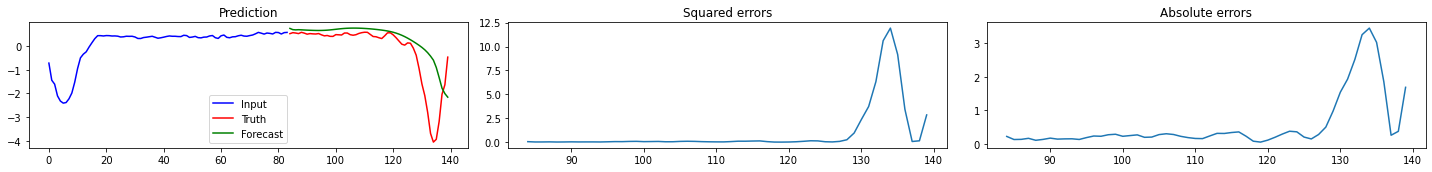

TDI: 0.42, TDM: 1.00 


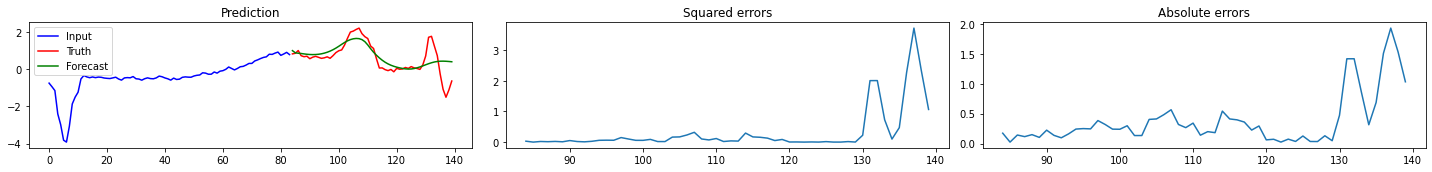

TDI: 0.09, TDM: 0.38 


TypeError: __init__() missing 1 required positional argument: 'method_name'

In [7]:
window = 84
horizon = 56

batch_size = 10
epochs = 20
lr = 0.01
 
# Load data
train = UCR18("../data/ECG5000/ECG5000_TRAIN.tsv", window, horizon)
test = UCR18("../data/ECG5000/ECG5000_TEST.tsv", window, horizon)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# Train and save model OR load model from pickle
if TRAIN_MODEL:
    
    encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
    decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
    model = GRUNet(encoder, decoder, horizon, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    
    train_model(model, optimizer, loss_fn, train_loader, epochs=epochs)
    
    with open('./saved_models/gru_ecg.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open('./saved_models/gru_ecg.pickle', 'rb') as handle:
        model = pickle.load(handle)

# Get forecasts
x_test, y_test, yhat_test = get_forecasts(model, test_loader)

# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

# Compute evaluation
res_ecg = Evaluation(y_test, yhat_test, "ECG5000", "GRU")

### Evaluation

In [ ]:
print(res_ecg)
res_ecg.plot()

# Dataset: Traffic

Training model: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:02<00:00, 30.15s/epoch, train_loss=3.19e-5]


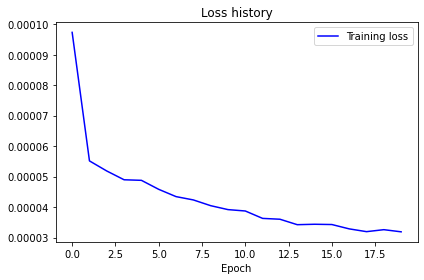

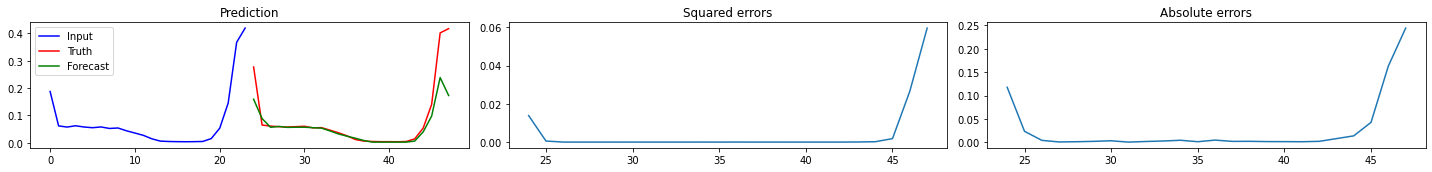

TDI: 0.04, TDM: -0.75 


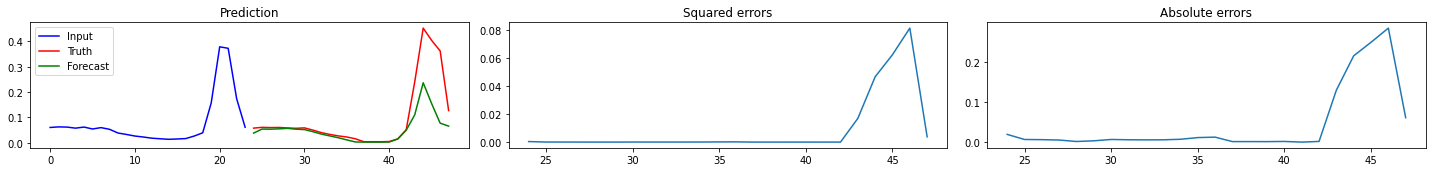

TDI: 0.09, TDM: -0.28 


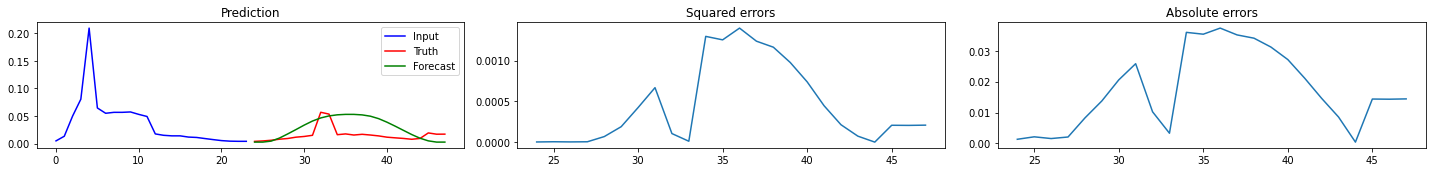

TDI: 0.21, TDM: 0.69 


..\metrics.py:76: RuntimeWarning: invalid value encountered in double_scalars
  tdi_late = abs(np.trapz(j_l[indices], j_l[indices] - i_l[indices]) / np.trapz(j_l, abs(j_l - i_l)))


In [7]:
# Parameters
window = 24
horizon = 24

batch_size = 32
epochs = 20
lr = 0.01
 
# Load data
ds = Traffic("../data/mvdata/traffic.txt", 24, 24, usecol=0)
train, test = split_dataset(ds, 0.2)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# Train and save model OR load model from pickle
if TRAIN_MODEL:
    
    encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
    decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
    model = GRUNet(encoder, decoder, horizon, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    train_model(model, optimizer, loss_fn, train_loader, epochs=epochs)
    
    with open('./saved_models/gru_traffic.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./saved_models/gru_traffic.pickle', 'rb') as handle:
        model = pickle.load(handle)

# Get forecasts on test
x_test, y_test, yhat_test = get_forecasts(model, test_loader)

# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

# Compute evaluation
res_traffic = Evaluation(y_test, yhat_test, "Traffic", "GRU")

### Evaluation

In [ ]:
print(res_traffic)
res_traffic.plot()